In [104]:
#Run the new window deformation

In [105]:
from openpiv import windef
from openpiv import tools, scaling, validation, filters, preprocess
import openpiv.pyprocess as process
from openpiv import pyprocess
from openpiv import widim
import numpy as np
import os
from time import time
import warnings


import matplotlib.pyplot as plt
%matplotlib inline  

folder = '/home/matteo/PIV/PIV'

In [121]:
# Experimental data

# Camera
resolution = (992,1004) #pixel
physical_window = (45,45) # m
pixel_depth = 8 # bit
dynamic_range = 2**pixel_depth # levels
scaling_factor = 1/(np.mean(physical_window)/np.mean(resolution)) # m/pixel
#dt = 0.0679 #sec
dt = 0.0012
image_number = '050'

In [122]:
frame_a  = tools.imread( folder + '/Images/A' + image_number + 'a.tif' )
frame_b  = tools.imread( folder + '/Images/A' +  image_number + 'b.tif' )

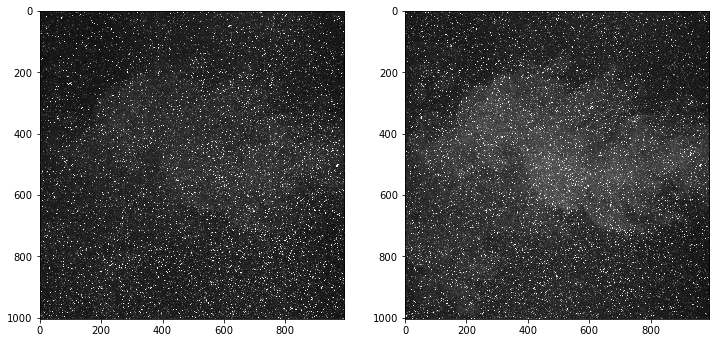

In [123]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [130]:
settings = windef.Settings()


'Data related settings'
# Folder with the images to process
settings.filepath_images = ''
# Folder for the outputs
settings.save_path = folder + '/win_def'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Test_1'
# Format and Image Sequence
settings.frame_pattern_a = folder + '/Images/A' + image_number + 'a.tif' 
settings.frame_pattern_b = folder + '/Images/A' + image_number + 'b.tif' 

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
settings.ROI = 'full'

'Image preprocessing'
# 'None' for no masking, 'edges' for edges masking, 'intensity' for intensity masking
# WARNING: This part is under development so better not to use MASKS
settings.dynamic_masking_method = 'None'
settings.dynamic_masking_threshold = 0.005
settings.dynamic_masking_filter_size = 7

settings.deformation_method = 'symmetric'

'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
settings.normalized_correlation=False

settings.num_iterations = 3  # select the number of PIV passes
# add the interroagtion window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes = (128,64,32) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
settings.overlap = (64,32,16) # This is 50% overlap
# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'
# order of the image interpolation for the window deformation
settings.interpolation_order = 3
settings.scaling_factor = scaling_factor  # scaling factor pixel/meter
settings.dt = 0.0012 #1/15 #0.0012 # time between to frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN
'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True
# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated
'Validation Parameters'
# The validation is done at each iteration based on three filters.
# The first filter is based on the min/max ranges. Observe that these values are defined in
# terms of minimum and maximum displacement in pixel/frames.
settings.MinMax_U_disp = (-12, 5)
settings.MinMax_V_disp = (-5, 5)
# The second filter is based on the global STD threshold
settings.std_threshold = 2  # threshold of the std validation
# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size=1 #defines the size of the local median
'Validation based on the signal to noise ratio'
# Note: only available when extract_sig2noise==True and only for the last
# pass of the interrogation
# Enable the signal to noise ratio validation. Options: True or False
settings.do_sig2noise_validation = True # This is time consuming
# minmum signal to noise ratio that is need for a valid vector
settings.sig2noise_threshold = 1.2
'Outlier replacement or Smoothing options'
# Replacment options for vectors which are masked as invalid by the validation
settings.replace_vectors = True # Enable the replacment. Chosse: True or False
settings.smoothn=True #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter
# select a method to replace the outliers: 'localmean', 'disk', 'distance'
settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 20
settings.filter_kernel_size = 2  # kernel size for the localmean method
'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = True
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.show_all_plots = True
settings.scale_plot = 10000  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings

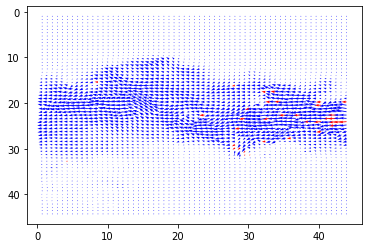

Image Pair 1


In [131]:
fig, ax = plt.subplots(figsize=(20,20))
windef.piv(settings)
ax.set_aspect('equal', 'box')

In [102]:
# Qua sotto solo per comodità c'è copiato lo script di win.

In [103]:
import os
import numpy as np
import scipy.ndimage as scn
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt

from openpiv.tools import imread, Multiprocesser, display_vector_field, \
    transform_coordinates
from openpiv import validation, filters, tools, preprocess, scaling, tools
from openpiv.pyprocess import extended_search_area_piv, get_coordinates, \
    get_field_shape
from openpiv import smoothn
from skimage.measure import points_in_poly
from skimage.util import invert


def piv(settings):
    """ the func fuction is the "frame" in which the PIV evaluation is done """

    def func(args):
        """A function to process each image pair."""

        # this line is REQUIRED for multiprocessing to work
        # always use it in your custom function

        file_a, file_b, counter = args

        # counter2=str(counter2)
        #####################
        # Here goes you code
        #####################

        " read images into numpy arrays"
        frame_a = imread(os.path.join(settings.filepath_images, file_a))
        frame_b = imread(os.path.join(settings.filepath_images, file_b))

        # Miguel: I just had a quick look, and I do not understand the reason
        # for this step.
        #  I propose to remove it.
        # frame_a = (frame_a*1024).astype(np.int32)
        # frame_b = (frame_b*1024).astype(np.int32)

        " crop to ROI"
        if settings.ROI == "full":
            frame_a = frame_a
            frame_b = frame_b
        else:
            frame_a = frame_a[
                settings.ROI[0]:settings.ROI[1],
                settings.ROI[2]:settings.ROI[3]
            ]
            frame_b = frame_b[
                settings.ROI[0]:settings.ROI[1],
                settings.ROI[2]:settings.ROI[3]
            ]

        if settings.invert is True:
            frame_a = invert(frame_a)
            frame_b = invert(frame_b)

        if settings.show_all_plots:
            fig, ax = plt.subplots(1,1)
            ax.imshow(frame_a, cmap=plt.get_cmap('Reds'))
            ax.imshow(frame_b, cmap=plt.get_cmap('Blues'),alpha=.5)
            plt.show()

        if settings.dynamic_masking_method in ("edge", "intensity"):
            frame_a, mask_a = preprocess.dynamic_masking(
                frame_a,
                method=settings.dynamic_masking_method,
                filter_size=settings.dynamic_masking_filter_size,
                threshold=settings.dynamic_masking_threshold,
            )
            frame_b, mask_b = preprocess.dynamic_masking(
                frame_b,
                method=settings.dynamic_masking_method,
                filter_size=settings.dynamic_masking_filter_size,
                threshold=settings.dynamic_masking_threshold,
            )

        # "first pass"
        x, y, u, v, s2n = first_pass(
            frame_a,
            frame_b,
            settings
        )

        if settings.show_all_plots:
            plt.figure()
            plt.quiver(x,y,u,-v,color='b')
            # plt.gca().invert_yaxis()
            # plt.gca().set_aspect(1.)
            # plt.title('after first pass, invert')
            # plt.show()

        # " Image masking "
        if settings.image_mask:
            image_mask = np.logical_and(mask_a, mask_b)
            mask_coords = preprocess.mask_coordinates(image_mask)
            # mark those points on the grid of PIV inside the mask
            grid_mask = preprocess.prepare_mask_on_grid(x,y,mask_coords)

            # mask the velocity
            u = np.ma.masked_array(u, mask=grid_mask)
            v = np.ma.masked_array(v, mask=grid_mask)
        else:
            mask_coords = []
            u = np.ma.masked_array(u, mask=np.ma.nomask)
            v = np.ma.masked_array(v, mask=np.ma.nomask)

        if settings.validation_first_pass:
            u, v, mask = validation.typical_validation(u, v, s2n, settings)

        if settings.show_all_plots:
            # plt.figure()
            plt.quiver(x,y,u,-v,color='r')
            plt.gca().invert_yaxis()
            plt.gca().set_aspect(1.)
            plt.title('after first pass validation new, inverted')
            plt.show()


        # "filter to replace the values that where marked by the validation"
        if settings.num_iterations == 1 and settings.replace_vectors:
            # for multi-pass we cannot have holes in the data
            # after the first pass
            u, v = filters.replace_outliers(
                u,
                v,
                method=settings.filter_method,
                max_iter=settings.max_filter_iteration,
                kernel_size=settings.filter_kernel_size,
            )
        elif settings.num_iterations > 1: # don't even check if it's true or false
            u, v = filters.replace_outliers(
                u,
                v,
                method=settings.filter_method,
                max_iter=settings.max_filter_iteration,
                kernel_size=settings.filter_kernel_size,
            )

            # "adding masks to add the effect of all the validations"
        if settings.smoothn:
            u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
                u, s=settings.smoothn_p
            )
            v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
                v, s=settings.smoothn_p
            )

        if settings.image_mask:
            grid_mask = preprocess.prepare_mask_on_grid(x, y, mask_coords)
            u = np.ma.masked_array(u, mask=grid_mask)
            v = np.ma.masked_array(v, mask=grid_mask)
        else:
            u = np.ma.masked_array(u, np.ma.nomask)
            v = np.ma.masked_array(v, np.ma.nomask)


        if settings.show_all_plots:
            plt.figure()
            plt.quiver(x,y,u,-v)
            plt.gca().invert_yaxis()
            plt.gca().set_aspect(1.)
            plt.title('before multi pass, inverted')
            plt.show()

        if not isinstance(u, np.ma.MaskedArray):
            raise ValueError("Expected masked array")
    
        """ Multi pass """
        
        for i in range(1, settings.num_iterations):

            if not isinstance(u, np.ma.MaskedArray):
                raise ValueError("Expected masked array")

            x, y, u, v, s2n, mask = multipass_img_deform(
                frame_a,
                frame_b,
                i,
                x,
                y,
                u,
                v,
                settings,
                mask_coords=mask_coords
            )        

            # If the smoothing is active, we do it at each pass
            # but not the last one
            if settings.smoothn is True and i < settings.num_iterations-1: 
                u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
                    u, s=settings.smoothn_p
                )
                v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
                    v, s=settings.smoothn_p
                )
            if not isinstance(u, np.ma.MaskedArray):
                raise ValueError ('not a masked array anymore')

            if hasattr(settings, 'image_mask') and settings.image_mask:
                grid_mask = preprocess.prepare_mask_on_grid(x, y, mask_coords)
                u = np.ma.masked_array(u, mask=grid_mask)
                v = np.ma.masked_array(v, mask=grid_mask)
            else:
                u = np.ma.masked_array(u, np.ma.nomask)
                v = np.ma.masked_array(v, np.ma.nomask)

            if settings.show_all_plots:
                plt.figure()
                plt.quiver(x, y, u, -v, color='r')
                plt.gca().set_aspect(1.)
                plt.gca().invert_yaxis()
                plt.title('end of the multipass, invert')
                plt.show()

        if settings.show_all_plots and settings.num_iterations > 1:
            plt.figure()
            plt.quiver(x,y,u,-v)
            plt.gca().invert_yaxis()
            plt.gca().set_aspect(1.)
            plt.title('after multi pass, before saving, inverted')
            plt.show()

        # we now use only 0s instead of the image
        # masked regions. 
        # we could do Nan, not sure what is best
        u = u.filled(0.)
        v = v.filled(0.)
        
        # "scales the results pixel-> meter"
        x, y, u, v = scaling.uniform(x, y, u, v,
                                     scaling_factor=settings.scaling_factor)
        
        if settings.image_mask:
            grid_mask = preprocess.prepare_mask_on_grid(x, y, mask_coords)
            u = np.ma.masked_array(u, mask=grid_mask)
            v = np.ma.masked_array(v, mask=grid_mask)
        else:
            u = np.ma.masked_array(u, np.ma.nomask)
            v = np.ma.masked_array(v, np.ma.nomask)

        # before saving we conver to the "physically relevant"
        # right-hand coordinate system with 0,0 at the bottom left
        # x to the right, y upwards
        # and so u,v

        x, y, u, v = transform_coordinates(x, y, u, v)
        # import pdb; pdb.set_trace()
        # "save to a file"
        tools.save(x, y, u, v, mask,
            os.path.join(save_path, "field_A%03d.txt" % counter),
            delimiter="\t",
        )
        
        # "some other stuff that one might want to use"
        if settings.show_plot or settings.save_plot:
            Name = os.path.join(save_path, "Image_A%03d.png" % counter)
            fig, _ = display_vector_field(
                os.path.join(save_path, "field_A%03d.txt" % counter),
                scale=settings.scale_plot,
            )
            if settings.save_plot is True:
                fig.savefig(Name)
            if settings.show_plot is True:
                plt.show()

        print(f"Image Pair {counter + 1}")
        print(file_a.rsplit('/')[-1],file_b.rsplit('/')[-1])


    # "Below is code to read files and create a folder to store the results"
    save_path = os.path.join(
        settings.save_path,
        "Open_PIV_results_"
        + str(settings.windowsizes[settings.num_iterations-1])
        + "_"
        + settings.save_folder_suffix,
    )
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    task = Multiprocesser(
        data_dir=settings.filepath_images,
        pattern_a=settings.frame_pattern_a,
        pattern_b=settings.frame_pattern_b,
    )
    task.run(func=func, n_cpus=1)


def create_deformation_field(frame, x, y, u, v, kx=3, ky=3):
    """
    Deform an image by window deformation where a new grid is defined based
    on the grid and displacements of the previous pass and pixel values are
    interpolated onto the new grid.
    Parameters
    ----------
    frame : 2d np.ndarray, dtype=np.int32
        an two dimensions array of integers containing grey levels of
        the first frame.
    x : 2d np.ndarray
        a two dimensional array containing the x coordinates of the
        interrogation window centers, in pixels.
    y : 2d np.ndarray
        a two dimensional array containing the y coordinates of the
        interrogation window centers, in pixels.
    u : 2d np.ndarray
        a two dimensional array containing the u velocity component,
        in pixels/seconds.
    v : 2d np.ndarray
        a two dimensional array containing the v velocity component,
        in pixels/seconds.
    interpolation_order: scalar
        the degree of the frame interpolation (deformation) of the mesh
    kx : scalar
         the degree of the interpolation of the B-splines over the x-axis
         of a rectangular mesh
    ky : scalar
         the degree of the interpolation of the B-splines over the
         y-axis of a rectangular mesh
    Returns
    -------
        x,y : new grid (after meshgrid)
        u,v : deformation field
    """
    y1 = y[:, 0]  # extract first coloumn from meshgrid
    x1 = x[0, :]  # extract first row from meshgrid
    side_x = np.arange(frame.shape[1])  # extract the image grid
    side_y = np.arange(frame.shape[0])

    # interpolating displacements onto a new meshgrid
    ip = RectBivariateSpline(y1, x1, u, kx=kx, ky=ky)
    ut = ip(side_y, side_x)
    # the way how to use the interpolation functions differs from matlab

    ip2 = RectBivariateSpline(y1, x1, v, kx=kx, ky=ky)
    vt = ip2(side_y, side_x)

    x, y = np.meshgrid(side_x, side_y)

    # plt.figure()
    # plt.quiver(x1,y1,u,-v,color='r')
    # plt.quiver(x,y,ut,-vt)
    # plt.gca().invert_yaxis()
    # plt.show()

    return x, y, ut, vt


def deform_windows(frame, x, y, u, v, interpolation_order=1, kx=3, ky=3, debugging=False):
    """
    Deform an image by window deformation where a new grid is defined based
    on the grid and displacements of the previous pass and pixel values are
    interpolated onto the new grid.
    Parameters
    ----------
    frame : 2d np.ndarray, dtype=np.int32
        an two dimensions array of integers containing grey levels of
        the first frame.
    x : 2d np.ndarray
        a two dimensional array containing the x coordinates of the
        interrogation window centers, in pixels.
    y : 2d np.ndarray
        a two dimensional array containing the y coordinates of the
        interrogation window centers, in pixels.
    u : 2d np.ndarray
        a two dimensional array containing the u velocity component,
        in pixels/seconds.
    v : 2d np.ndarray
        a two dimensional array containing the v velocity component,
        in pixels/seconds.
    interpolation_order: scalar
        the degree of the frame interpolation (deformation) of the mesh
    kx : scalar
         the degree of the interpolation of the B-splines over the x-axis
         of a rectangular mesh
    ky : scalar
         the degree of the interpolation of the B-splines over the
         y-axis of a rectangular mesh
    Returns
    -------
    frame_def:
        a deformed image based on the meshgrid and displacements of the
        previous pass
    """
    
    frame = frame.astype(np.float32)
    x, y, ut, vt = \
        create_deformation_field(frame,
                                 x, y, u, v,
                                 kx=kx, ky=ky)
    frame_def = scn.map_coordinates(
        frame, ((y - vt, x + ut,)), order=interpolation_order, mode='nearest')

    if debugging:
        plt.figure()
        plt.quiver(x, y, ut, vt)
        plt.title('new, x,y, ut,vt')
        plt.show()

        plt.figure()
        plt.imshow(frame-frame_def)
        plt.title('new deformed image')
        plt.show()
    

    return frame_def


def first_pass(frame_a, frame_b, settings):
    # window_size,
    # overlap,
    # iterations,
    # correlation_method="circular",
    # normalized_correlation=False,
    # subpixel_method="gaussian",
    # do_sig2noise=False,
    # sig2noise_method="peak2peak",
    # sig2noise_mask=2,
    # settings):
    """
    First pass of the PIV evaluation.
    This function does the PIV evaluation of the first pass. It returns
    the coordinates of the interrogation window centres, the displacment
    u and v for each interrogation window as well as the mask which indicates
    wether the displacement vector was interpolated or not.
    Parameters
    ----------
    frame_a : 2d np.ndarray
        the first image
    frame_b : 2d np.ndarray
        the second image
    window_size : int
         the size of the interrogation window
    overlap : int
        the overlap of the interrogation window, typically it is window_size/2
    subpixel_method: string
        the method used for the subpixel interpolation.
        one of the following methods to estimate subpixel location of the peak:
        'centroid' [replaces default if correlation map is negative],
        'gaussian' [default if correlation map is positive],
        'parabolic'
    Returns
    -------
    x : 2d np.array
        array containg the x coordinates of the interrogation window centres
    y : 2d np.array
        array containg the y coordinates of the interrogation window centres
    u : 2d np.array
        array containing the u displacement for every interrogation window
    u : 2d np.array
        array containing the u displacement for every interrogation window
    """

    #     if do_sig2noise is False or iterations != 1:
    #         sig2noise_method = None  # this indicates to get out nans

    u, v, s2n = extended_search_area_piv(
        frame_a,
        frame_b,
        window_size=settings.windowsizes[0],
        overlap=settings.overlap[0],
        search_area_size=settings.windowsizes[0],
        width=settings.sig2noise_mask,
        subpixel_method=settings.subpixel_method,
        sig2noise_method=settings.sig2noise_method,
        correlation_method=settings.correlation_method,
        normalized_correlation=settings.normalized_correlation
    )

    shapes = np.array(get_field_shape(frame_a.shape,
                                      settings.windowsizes[0],
                                      settings.overlap[0]))
    u = u.reshape(shapes)
    v = v.reshape(shapes)
    s2n = s2n.reshape(shapes)

    x, y = get_coordinates(frame_a.shape,
                           settings.windowsizes[0],
                           settings.overlap[0])

    return x, y, u, v, s2n


def multipass_img_deform(
    frame_a,
    frame_b,
    current_iteration,
    x_old,
    y_old,
    u_old,
    v_old,
    settings,
    mask_coords=[],
):
    # window_size,
    # overlap,
    # iterations,
    # current_iteration,
    # x_old,
    # y_old,
    # u_old,
    # v_old,
    # correlation_method="circular",
    # normalized_correlation=False,
    # subpixel_method="gaussian",
    # deformation_method="symmetric",
    # sig2noise_method="peak2peak",
    # sig2noise_threshold=1.0,
    # sig2noise_mask=2,
    # interpolation_order=1,

    """
    Multi pass of the PIV evaluation.
    This function does the PIV evaluation of the second and other passes.
    It returns the coordinates of the interrogation window centres,
    the displacement u, v for each interrogation window as well as
    the signal to noise ratio array (which is full of NaNs if opted out)
    Parameters
    ----------
    frame_a : 2d np.ndarray
        the first image
    frame_b : 2d np.ndarray
        the second image
    window_size : tuple of ints
         the size of the interrogation window
    overlap : tuple of ints
        the overlap of the interrogation window, e.g. window_size/2
    x_old : 2d np.ndarray
        the x coordinates of the vector field of the previous pass
    y_old : 2d np.ndarray
        the y coordinates of the vector field of the previous pass
    u_old : 2d np.ndarray
        the u displacement of the vector field of the previous pass
        in case of the image mask - u_old and v_old are MaskedArrays
    v_old : 2d np.ndarray
        the v displacement of the vector field of the previous pass
    subpixel_method: string
        the method used for the subpixel interpolation.
        one of the following methods to estimate subpixel location of the peak:
        'centroid' [replaces default if correlation map is negative],
        'gaussian' [default if correlation map is positive],
        'parabolic'
    interpolation_order : int
        the order of the spline interpolation used for the image deformation
    mask_coords : list of x,y coordinates (pixels) of the image mask,
        default is an empty list
    Returns
    -------
    x : 2d np.array
        array containg the x coordinates of the interrogation window centres
    y : 2d np.array
        array containg the y coordinates of the interrogation window centres
    u : 2d np.array
        array containing the horizontal displacement for every interrogation
        window [pixels]
    u : 2d np.array
        array containing the vertical displacement for every interrogation
        window it returns values in [pixels]
    s2n : 2D np.array of signal to noise ratio values
    """

    if not isinstance(u_old, np.ma.MaskedArray):
        raise ValueError ('Expected masked array')

    # calculate the y and y coordinates of the interrogation window centres.
    # Hence, the
    # edges must be extracted to provide the sufficient input. x_old and y_old
    # are the coordinates of the old grid. x_int and y_int are the coordinates
    # of the new grid

    window_size = settings.windowsizes[current_iteration]
    overlap = settings.overlap[current_iteration]

    x, y = get_coordinates(frame_a.shape,
                           window_size,
                           overlap)

    # The interpolation function dont like meshgrids as input. 
    # plus the coordinate system for y is now from top to bottom
    # and RectBivariateSpline wants an increasing set

    y_old = y_old[:, 0]
    # y_old = y_old[::-1]
    x_old = x_old[0, :]

    y_int = y[:, 0]
    # y_int = y_int[::-1]
    x_int = x[0, :]



    # interpolating the displacements from the old grid onto the new grid
    # y befor x because of numpy works row major
    ip = RectBivariateSpline(y_old, x_old, u_old.filled(0.))
    u_pre = ip(y_int, x_int)

    ip2 = RectBivariateSpline(y_old, x_old, v_old.filled(0.))
    v_pre = ip2(y_int, x_int)
    
    # if settings.show_plot:
    if settings.show_all_plots:
        plt.figure()
        plt.quiver(x_old, y_old, u_old, -v_old,color='b')
        plt.quiver(x_int, y_int, u_pre, -v_pre,color='r',lw=2)
        plt.gca().set_aspect(1.)
        plt.gca().invert_yaxis()
        plt.title('inside deform, invert')
        plt.show()

    # @TKauefer added another method to the windowdeformation, 'symmetric'
    # splits the onto both frames, takes more effort due to additional
    # interpolation however should deliver better results

    old_frame_a = frame_a.copy()
    old_frame_b = frame_b.copy()


    # Image deformation has to occur in image coordinates
    # therefore we need to convert the results of the
    # previous pass which are stored in the physical units
    # and so y from the get_coordinates

    if settings.deformation_method == "symmetric":
        # this one is doing the image deformation (see above)
        x_new, y_new, ut, vt = create_deformation_field(
            frame_a, x, y, u_pre, v_pre)
        frame_a = scn.map_coordinates(
            frame_a, ((y_new - vt / 2, x_new - ut / 2)),
            order=settings.interpolation_order, mode='nearest')
        frame_b = scn.map_coordinates(
            frame_b, ((y_new + vt / 2, x_new + ut / 2)),
            order=settings.interpolation_order, mode='nearest')
    elif settings.deformation_method == "second image":
        frame_b = deform_windows(
            frame_b, x, y, u_pre, -v_pre,
            interpolation_order=settings.interpolation_order)
    else:
        raise Exception("Deformation method is not valid.")

    # if settings.show_plot:
    if settings.show_all_plots:
        if settings.deformation_method == 'symmetric':
            plt.figure()
            plt.imshow(frame_a-old_frame_a)
            plt.show()

        plt.figure()
        plt.imshow(frame_b-old_frame_b)
        plt.show()

    # if do_sig2noise is True 
    #     sig2noise_method = sig2noise_method
    # else:
    #     sig2noise_method = None

    # so we use here default circular not normalized correlation:
    # if we did not want to validate every step, remove the method
    if settings.sig2noise_validate is False:
        settings.sig2noise_method = None

    u, v, s2n = extended_search_area_piv(
        frame_a,
        frame_b,
        window_size=window_size,
        overlap=overlap,
        width=settings.sig2noise_mask,
        subpixel_method=settings.subpixel_method,
        sig2noise_method=settings.sig2noise_method,  # if it's None, it's not used
        correlation_method=settings.correlation_method,
        normalized_correlation=settings.normalized_correlation,
    )

    shapes = np.array(get_field_shape(frame_a.shape,
                                      window_size,
                                      overlap))
    u = u.reshape(shapes)
    v = v.reshape(shapes)
    s2n = s2n.reshape(shapes)


    u += u_pre
    v += v_pre

    # reapply the image mask to the new grid
    if settings.image_mask:
        grid_mask = preprocess.prepare_mask_on_grid(x, y, mask_coords)
        u = np.ma.masked_array(u, mask=grid_mask)
        v = np.ma.masked_array(v, mask=grid_mask)
    else:
        u = np.ma.masked_array(u, np.ma.nomask)
        v = np.ma.masked_array(v, np.ma.nomask)


    # validate in the multi-pass by default
    u, v, mask = validation.typical_validation(u, v, s2n, settings)

    if np.all(mask == True):
        raise ValueError("Something happened in the validation")

    if not isinstance(u, np.ma.MaskedArray):
        raise ValueError ('not a masked array anymore')

    if settings.show_all_plots:
        plt.figure()
        nans = mask == True

        plt.quiver(x[~nans], y[~nans], u[~nans], -v[~nans], color='b')
        plt.quiver(x[nans], y[nans], u[nans], -v[nans], color='r')
        plt.gca().invert_yaxis()
        plt.gca().set_aspect(1.)
        plt.title('After sig2noise, inverted')
        plt.show()
    
    # we have to replace outliers
    u, v = filters.replace_outliers(
        u,
        v,
        method=settings.filter_method,
        max_iter=settings.max_filter_iteration,
        kernel_size=settings.filter_kernel_size,
    )

    # reapply the image mask to the new grid
    if settings.image_mask:
        grid_mask = preprocess.prepare_mask_on_grid(x, y, mask_coords)
        u = np.ma.masked_array(u, mask=grid_mask)
        v = np.ma.masked_array(v, mask=grid_mask)
    else:
        u = np.ma.masked_array(u, np.ma.nomask)
        v = np.ma.masked_array(v, np.ma.nomask) 



    if settings.show_all_plots:
        plt.figure()
        plt.quiver(x, y, u, -v, color='r')
        plt.quiver(x, y, u_pre, -v_pre,color='b')
        plt.gca().invert_yaxis()
        plt.gca().set_aspect(1.)
        plt.title(' after replaced outliers, red, invert')
        plt.show()

    return x, y, u, v, s2n, mask

class FrozenClass(object):
    __isfrozen = False
    def __setattr__(self, key, value):
        if self.__isfrozen and not hasattr(self, key):
            raise TypeError( "%r is a frozen class" % self )
        object.__setattr__(self, key, value)

    def _freeze(self):
        self.__isfrozen = True

class Settings(FrozenClass):
    def __init__(self):
        # "Data related settings"
        # Folder with the images to process
        self.filepath_images = "."
        # Folder for the outputs
        self.save_path = "./res"
        # Root name of the output Folder for Result Files
        self.save_folder_suffix = "Test_4"
        # Format and Image Sequence
        self.frame_pattern_a = 'exp1_001_a.bmp'
        self.frame_pattern_b = 'exp1_001_b.bmp'

        # "Region of interest"
        # (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full'
        # for full image
        self.ROI = "full"

        # "Image preprocessing"
        # 'None' for no masking, 'edges' for edges masking, 'intensity' for
        # intensity masking
        # WARNING: This part is under development so better not to use MASKS
        self.dynamic_masking_method = "None"
        self.dynamic_masking_threshold = 0.005
        self.dynamic_masking_filter_size = 7

        # "Processing Parameters"
        self.correlation_method = "circular"  # 'circular' or 'linear'
        self.normalized_correlation = False

        # add the interroagtion window size for each pass.
        # For the moment, it should be a power of 2
        self.windowsizes = (
            64,
            32,
            16,
        )  # if longer than n iteration the rest is ignored
        # The overlap of the interroagtion window for each pass.
        self.overlap = (32, 16, 8)  # This is 50% overlap
        # Has to be a value with base two. In general window size/2 is a good
        # choice.

        self.num_iterations = len(self.windowsizes)  # select the number of PIV
        # passes

        # methode used for subpixel interpolation:
        # 'gaussian','centroid','parabolic'
        self.subpixel_method = "gaussian"
        # 'symmetric' or 'second image', 'symmetric' splits the deformation
        # both images, while 'second image' does only deform the second image.
        self.deformation_method = 'symmetric'  # 'symmetric' or 'second image'
        # order of the image interpolation for the window deformation
        self.interpolation_order = 3
        self.scaling_factor = 1  # scaling factor pixel/meter
        self.dt = 1  # time between to frames (in seconds)

        # "Signal to noise ratio options (only for the last pass)"
        # It is possible to decide if the S/N should be computed (for the last
        # pass) or not
        # 'True' or 'False' (only for the last pass)
        # self.extract_sig2noise = False
        # method used to calculate the signal to noise ratio 'peak2peak' or
        # 'peak2mean'
        self.sig2noise_method = "peak2peak" # or "peak2mean" or "None"
        # select the width of the masked to masked out pixels next to the main
        # peak
        self.sig2noise_mask = 2
        # If extract_sig2noise==False the values in the signal to noise ratio
        # output column are set to NaN

        # "vector validation options"
        # choose if you want to do validation of the first pass: True or False
        self.validation_first_pass = True
        # only effecting the first pass of the interrogation the following
        # passes
        # in the multipass will be validated

        # "Validation Parameters"
        # The validation is done at each iteration based on three filters.
        # The first filter is based on the min/max ranges. Observe that these
        # values are defined in
        # terms of minimum and maximum displacement in pixel/frames.
        self.MinMax_U_disp = (-30, 30)
        self.MinMax_V_disp = (-30, 30)
        # The second filter is based on the global STD threshold
        self.std_threshold = 10  # threshold of the std validation
        # The third filter is the median test (not normalized at the moment)
        self.median_threshold = 3  # threshold of the median validation
        # On the last iteration, an additional validation can be done based on
        # the S/N.
        self.median_size = 1  # defines the size of the local median

        # "Validation based on the signal to noise ratio"
        # Note: only available when extract_sig2noise==True and only for the
        # last pass of the interrogation
        # Enable the signal to noise ratio validation. Options: True or False
        # self.sig2noise_validate = False  # This is time consuming
        # minmum signal to noise ratio that is need for a valid vector
        self.sig2noise_threshold = 1.0
        self.sig2noise_validate = True

        # "Outlier replacement or Smoothing options"
        # Replacment options for vectors which are masked as invalid by the
        # validation
        # Choose: True or False
        self.replace_vectors = True  # Enable the replacement.
        self.smoothn = True  # Enables smoothing of the displacement field
        self.smoothn_p = 0.05  # This is a smoothing parameter
        # select a method to replace the outliers:
        # 'localmean', 'disk', 'distance'
        self.filter_method = "localmean"
        # maximum iterations performed to replace the outliers
        self.max_filter_iteration = 4
        self.filter_kernel_size = 2  # kernel size for the localmean method

        # "Output options"
        # Select if you want to save the plotted vectorfield: True or False
        self.save_plot = True
        # Choose wether you want to see the vectorfield or not :True or False
        self.show_plot = True
        self.scale_plot = 100  # select a value to scale the quiver plot of
        # the vectorfield run the script with the given settings

        self.image_mask = False

        self.show_all_plots = False

        self.invert = False # for the test_invert

        self._freeze()


if __name__ == "__main__":
    """ Run windef.py as a script:
    python windef.py
    """

    settings = Settings()
    piv(settings)

ImportError: cannot import name 'transform_coordinates' from 'openpiv.tools' (/home/matteo/.local/lib/python3.8/site-packages/openpiv/tools.py)

In [ ]:
x, y = get_coordinates(frame_a.shape,
                           window_size,
                           overlap)